In [1]:
%run init_notebook.py

In [2]:
import scipy

In [31]:
g1 = scipy.stats.norm(2, 10)
g2 = scipy.stats.norm(3, 5)

In [32]:
def mul_gaussians(g1, g2):
    mu = (g1.std() * g2.mean() + g2.std() * g1.mean()) / (g1.std() + g2.std())
    sig = g1.std() * g2.std() / (g1.std() + g2.std())
    return scipy.stats.norm(mu, sig)

In [35]:
signal

[(3.0, 5),
 (3.1, 5),
 (3.2, 5),
 (3.3, 5),
 (3.4, 5),
 (3.5, 5),
 (3.6, 5),
 (3.7, 5),
 (3.8, 5),
 (3.9, 5)]

In [72]:
obs_sig

[(3.0, 2)]

''

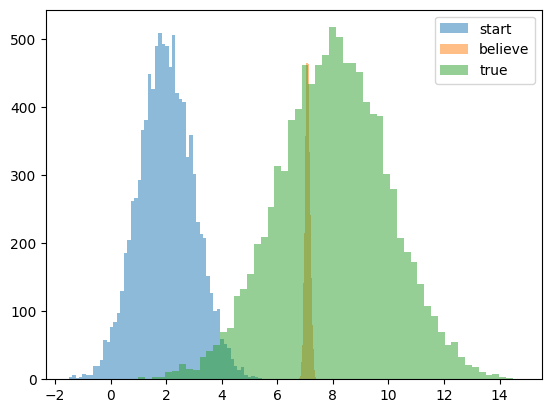

In [108]:
T = 100

g0 = scipy.stats.norm(2, 1)

true_sig = [(3, 2) if i <= 7 else (8, 2) for i in range(T)]
obs_sig = [(i[0], i[1] * 5) for i in true_sig]
g_true = scipy.stats.norm(true_sig[-1][0], true_sig[-1][1])

g = g0
for t in range(T):
    g = mul_gaussians(g,scipy.stats.norm(obs_sig[t][0], obs_sig[t][1]))

plt.hist(g0.rvs(10000), bins='fd', alpha=.5)
plt.hist(g.rvs(10000), bins='fd', alpha=.5)
plt.hist(g_true.rvs(10000), bins='fd', alpha=.5)
plt.legend(['start', 'believe', 'true'])
;

In [109]:
g.mean(), g_true.mean()

(7.0909090909090935, 8.0)